# Generate the `kombucha` dataset


TODOs:
- [ ] vary sample sizes

In [1]:
datafilepath = "../datasets/kombucha.csv"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from scipy.stats import norm
from scipy.stats import chi2

## Generate the batches

In [4]:
default_n = 40
default_params = (1000, 10)
default_settings = {"n":default_n, "params":default_params}


nbatches = 10
# batch indices go from `1` until `nbatches+1`
batch_settings = {
    1: {"seed":1, "n":40},
    2: {"seed":2, "n":20},
    3: {"seed":3, "n":30},
    4: {"seed":4, "params":(1005,10)},
    5: {"seed":5, "params":(1002,10)},
    6: {"seed":6, "params":( 995,10), },
    7: {"seed":7, "params":( 999,10)},
    8: {"seed":34, "params":(1000,14)},
    9: {"seed":36, "params":(1000,11)},
    10: {"seed":10}, # outlier added later...
}

outliers_to_add = {
    10: {"index":3, "value":1060}
}


np.random.seed(15)
data = {
    "batch": [],
    "volume": []
}
for batch in range(1, nbatches+1):
    print("Generating batch", batch)
    settings = batch_settings.get(batch, default_settings)
    mu, sigma = settings.get("params", default_params)
    rvK = norm(mu, sigma)
    n = settings.get("n", default_n)
    
    if "seed" in settings:
        np.random.seed(settings["seed"])
    else:
        np.random.seed(batch)
    volumes = rvK.rvs(n)
    volumes = volumes.round(2)

    if batch in outliers_to_add:
        outliers_dict = outliers_to_add[batch]
        print("  adding outliers", outliers_dict)
        index = outliers_dict["index"]
        assert index < n, "outlier index out of range"
        value = outliers_dict["value"]
        volumes[index] = value

    data["batch"].extend([batch]*n)
    data["volume"].extend(volumes)

kombucha = pd.DataFrame(data)

Generating batch 1
Generating batch 2
Generating batch 3
Generating batch 4
Generating batch 5
Generating batch 6
Generating batch 7
Generating batch 8
Generating batch 9
Generating batch 10
  adding outliers {'index': 3, 'value': 1060}


### Descriptive statistics checks

In [5]:
summary = kombucha.groupby("batch").describe()
summary.columns = summary.columns.droplevel()
summary['count'] = summary['count'].astype(int)
summary = summary.rename(columns={"count":"n"}) \
                 .drop(columns=["25%", "50%", "75%"])
summary

,n,mean,std,min,max
batch,,,,,
1,40,999.10375,9.769163,976.98,1017.45
2,20,997.90700,11.149780,978.64,1022.92
3,30,998.75100,9.248441,981.37,1017.89
4,40,1005.47575,10.408956,981.42,1027.23
5,40,1002.59700,9.102913,985.35,1026.31
6,40,995.99550,10.749074,970.13,1021.31
7,40,997.99775,10.813894,976.12,1019.29
8,40,999.07100,13.038325,970.67,1025.41
9,40,996.82600,12.181816,975.83,1024.61


In [6]:
# # SAVE TO DATAFILE
# kombucha.to_csv(datafilepath, index=False)

In [7]:
# RELOAD FROM DATAFILE
kombucha = pd.read_csv(datafilepath)
kombucha.head()

,batch,volume
0,1,1016.24
1,1,993.88
2,1,994.72
3,1,989.27
4,1,1008.65


### Visual inspection

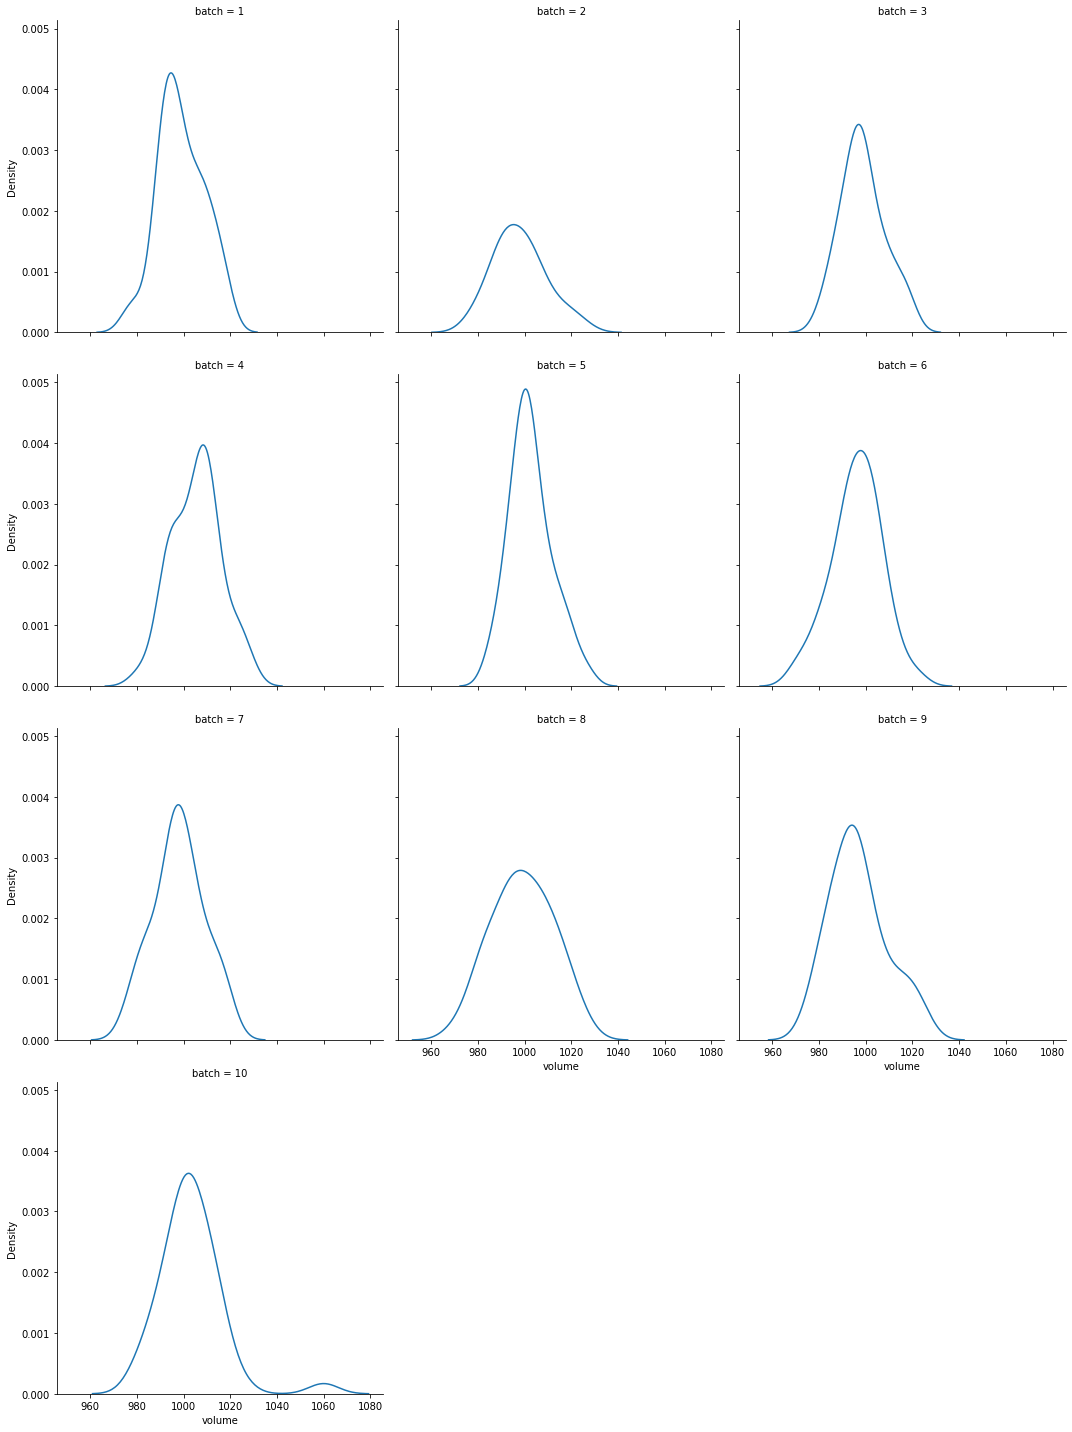

In [8]:
sns.displot(x="volume", col="batch", kind="kde", data=kombucha, col_wrap=3)

## Tests

In [9]:
pop_mu, pop_sigma = default_params

def ztest(sample, mu=pop_mu, sigma=pop_sigma):
    """
    Z-test to detect mean deviation from known normal population.
    """
    mean = np.mean(sample)
    n = len(sample)
    se = sigma / np.sqrt(n)
    obsz = (mean - mu) / se
    absz = abs(obsz)
    pval = norm.cdf(-absz) + 1-norm.cdf(absz)
    return obsz, pval

def chi2test(sample, sigma=pop_sigma, onesided=False):
    """
    Two-sided chi2 test to detect sample variance deviation
    from a known population variance `sigma`.
    """
    n = len(sample)
    s2 = sample.var()
    obschi2 = (n-1)*s2 / sigma**2
    df = n-1
    rvX2 = chi2(df)
    if onesided:
        pval = 1-rvX2.cdf(obschi2)
    else:
        p_lower = rvX2.cdf(obschi2)
        p_upper = 1-rvX2.cdf(obschi2)
        pval = 2*min(p_lower, p_upper)
    return obschi2, pval

### Two normal batches


In [10]:
kombu01 = kombucha[kombucha["batch"]==1]["volume"].values
kombu02 = kombucha[kombucha["batch"]==2]["volume"].values

assert ztest(kombu01)[1] > 0.05
assert ztest(kombu02)[1] > 0.05
assert chi2test(kombu01)[1] > 0.05
assert chi2test(kombu02)[1] > 0.05

### Mean different from population


In [11]:
kombu04 = kombucha[kombucha["batch"]==4]["volume"].values
kombu05 = kombucha[kombucha["batch"]==5]["volume"].values
kombu06 = kombucha[kombucha["batch"]==6]["volume"].values
kombu07 = kombucha[kombucha["batch"]==7]["volume"].values

# 04 = batch mean too large (significant)
assert ztest(kombu04)[1] < 0.05

# 05 = batch mean too large (not significant)
assert ztest(kombu05)[1] > 0.05
assert ztest(kombu05)[1] < 0.30

# 06 = batch mean too small (significant)
assert ztest(kombu06)[1] < 0.05

# 07 = batch mean too small (not significant)
assert ztest(kombu07)[1] > 0.05
assert ztest(kombu07)[1] < 0.30

### Variance different from population

In [12]:
kombu08 = kombucha[kombucha["batch"]==8]["volume"].values
kombu09 = kombucha[kombucha["batch"]==9]["volume"].values

# 08 = batch variance too high (significant)
assert chi2test(kombu08)[1] < 0.05

# 09 = batch variance too high (not significant 2-tailed, ...
assert chi2test(kombu09)[1] > 0.05

# ... but significant 1-tailed
assert chi2test(kombu09, onesided=True)[1] < 0.05

### One batch with outlier

<AxesSubplot:>

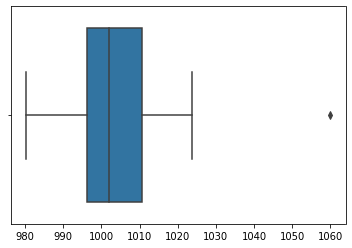

In [13]:
kombu10 = kombucha[kombucha["batch"]==10]["volume"].values
assert chi2test(kombu10)[1] < 0.05
assert ztest(kombu10)[1] < 0.05
sns.boxplot(x=kombu10)

## Enhanced summary

In [14]:
summary2 = summary.copy()

In [15]:
zvalues = pd.Series(dtype=float)
zpvalues = pd.Series(dtype=float)
for batch in range(1, nbatches+1):
    sample = kombucha[kombucha["batch"]==batch]["volume"].values
    zval, pval = ztest(sample)
    zvalues.loc[batch] = zval
    zpvalues.loc[batch] = pval

summary2["z"] = zvalues.round(2)
summary2["p-val (z)"] = zpvalues.round(3)

In [16]:
chi2values = pd.Series(dtype=float)
chi2pvalues = pd.Series(dtype=float)
for batch in range(1, nbatches+1):
    sample = kombucha[kombucha["batch"]==batch]["volume"].values
    chi2val, pval = chi2test(sample)
    chi2values.loc[batch] = chi2val
    chi2pvalues.loc[batch] = pval

summary2["chi2"] = chi2values.round(2)
summary2["p-val (chi2)"] = chi2pvalues.round(3)

In [17]:
def color_red_or_black(val):
    color = 'red' if val < 0.05 else 'black'
    return 'color: %s' % color

summary2.style.applymap(
    color_red_or_black,
    subset=pd.IndexSlice[:, ["p-val (z)", "p-val (chi2)"]]
).format(precision=3)  

,n,mean,std,min,max,z,p-val (z),chi2,p-val (chi2)
batch,,,,,,,,,
1,40,999.104,9.769,976.980,1017.450,-0.570,0.571,36.290,0.812
2,20,997.907,11.150,978.640,1022.920,-0.940,0.349,22.440,0.526
3,30,998.751,9.248,981.370,1017.890,-0.680,0.494,23.980,0.540
4,40,1005.476,10.409,981.420,1027.230,3.460,0.001,41.200,0.749
5,40,1002.597,9.103,985.350,1026.310,1.640,0.100,31.510,0.405
6,40,995.995,10.749,970.130,1021.310,-2.530,0.011,43.940,0.541
7,40,997.998,10.814,976.120,1019.290,-1.270,0.205,44.470,0.505
8,40,999.071,13.038,970.670,1025.410,-0.590,0.557,64.640,0.012
9,40,996.826,12.182,975.830,1024.610,-2.010,0.045,56.430,0.070


## Population file (data for a whole batch)

In [18]:
popdatafilepath = "../datasets/kombuchapop.csv"

N = 1000  # size of a whole batch (population)
pop_batch_settings = {
    55: {"seed":55, "n":1000},
    56: {"seed":56, "n":1000, "params":(1004,10)},
}


np.random.seed(99)
popdata = {
    "batch": [],
    "volume": []
}
for batch in [55,56]:
    print("Generating batch", batch)
    settings = pop_batch_settings.get(batch, default_settings)
    mu, sigma = settings.get("params", default_params)
    rvK = norm(mu, sigma)
    n = settings.get("n", default_n)
    
    if "seed" in settings:
        np.random.seed(settings["seed"])
    else:
        np.random.seed(batch)
    volumes = rvK.rvs(n)
    volumes = volumes.round(2)

    if batch in outliers_to_add:
        outliers_dict = outliers_to_add[batch]
        print("  adding outliers", outliers_dict)
        index = outliers_dict["index"]
        assert index < n, "outlier index out of range"
        value = outliers_dict["value"]
        volumes[index] = value

    popdata["batch"].extend([batch]*n)
    popdata["volume"].extend(volumes)

kombuchapop = pd.DataFrame(popdata)

Generating batch 55
Generating batch 56


In [19]:
kombuchapop.groupby("batch").describe()

volume                                                              \
        count        mean       std     min       25%      50%        75%   
batch                                                                       
55     1000.0  1000.14613  9.969847  968.84  993.2025  1000.25  1006.4950   
56     1000.0  1003.98871  9.809968  974.31  997.6950  1003.53  1010.3525   

                
           max  
batch           
55     1047.87  
56     1035.34

In [20]:
# SAVE TO DATAFILE
kombuchapop.to_csv(popdatafilepath, index=False)

In [25]:
# RELOAD FROM DATAFILE
kombuchapop = pd.read_csv(popdatafilepath)
kombuchapop.sample(5)

,batch,volume
1329,56,997.39
554,55,986.31
1112,56,1019.24
34,55,1012.11
548,55,989.44


In [22]:
# 55 = is normal
kombu55 = kombuchapop[kombuchapop["batch"]==55]["volume"].values
# np.random.seed(30)
# sample5520 = np.random.choice(kombu55, size=20, replace=False)

for size in [10, 20, 30, 40, 50]:
    sample = kombu55[0:size]
    print(ztest(sample))

(-0.7959452870643978, 0.42606383719455554)
(0.24015370078359455, 0.8102111048475793)
(0.12305500125280257, 0.9020635441770586)
(-0.04016092628412347, 0.9679648287896927)
(-0.10451038225934421, 0.9167643295479251)


In [23]:
# 56 = is too full
kombu56 = kombuchapop[kombuchapop["batch"]==56]["volume"].values

# np.random.seed(31)
# sample5620 = np.random.choice(kombu56, size=20, replace=False)

for size in [10, 20, 30, 40, 50]:
    sample = kombu56[0:size]
    print(ztest(sample))

(0.6470020092704301, 0.5176306430714832)
(2.36240581822854, 0.018156754278758735)
(2.050855829485105, 0.04028098874421315)
(2.342299062886695, 0.019165350874670306)
(2.5445944627779338, 0.010940471575400235)
